In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install scikeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 101.0 MB/s eta 0:00:0000:01:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.


In [3]:
!pip install --upgrade scikit-learn scikeras

In [4]:
!pip install keras-tuner

In [5]:
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Cropping2D, Input, Rescaling
from tensorflow.keras.applications import ResNet50
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc

In [6]:
test_dir = '/kaggle/input/histopathologic-cancer-detection/test/'
train_dir = '/kaggle/input/histopathologic-cancer-detection/train/'
train_labels_file = '/kaggle/input/histopathologic-cancer-detection/train_labels.csv'
test_labels_file = '/kaggle/input/histopathologic-cancer-detection/sample_submission.csv'

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # Detect TPU
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print("Running on TPU!")
except:
    strategy = tf.distribute.get_strategy()  # Default to GPU/CPU
    print("Running on CPU/GPU")

<div style="background-color: #1f77b4; color: white; padding: 10px; border-radius: 10px; text-align: center; font-size: 24px; font-weight: bold;">
    Histopathologic Cancer Detection
</div>

<div style="background-color: #76c7c0; color: white; padding: 10px; border-radius: 10px; text-align: center; font-size: 24px; font-weight: bold;">
    Problem Statement
</div>

The goal is to create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans and predict a probability that center 32x32px region of a patch contains at least one pixel of tumor tissue.

## Data

The data is a slightly modified version of the PatchCamelyon (PCam) [benchmark dataset](https://github.com/basveeling/pcam).

### Dataset Structure

Dataset consists of two main folders (train & test) and one CSV file for labels:

* train/ – Contains labeled histopathologic images.
* test/ – Contains unlabeled images for predictions.
* train_labels.csv – A CSV file mapping image IDs to labels (0 = benign, 1 = malignant).



<div style="background-color: #76c7c0; color: white; padding: 10px; border-radius: 10px; text-align: center; font-size: 24px; font-weight: bold;">
    EDA
</div>

In [7]:
train_labels = pd.read_csv(train_labels_file)
test_labels = pd.read_csv(test_labels_file)

num_train_images = len(os.listdir(train_dir))
num_test_images = len(os.listdir(test_dir))
num_labels = train_labels.shape[0]

print(f"Number of training images: {num_train_images}")
print(f"Number of test images: {num_test_images}")
print(f"Number of labeled images: {num_labels}")

Number of training images: 220025
Number of test images: 57458
Number of labeled images: 220025


In [ ]:
train_labels.head()

In [ ]:
sample_image_path = os.path.join(train_dir, os.listdir(train_dir)[0])
img = Image.open(sample_image_path)

print(f"Image size: {img.size}")
print(f"Image mode: {img.mode}")

img_array = np.array(img)
print(f"Image shape: {img_array.shape}")

Image samples:

In [ ]:
benign_samples = train_labels[train_labels["label"] == 0].sample(3)["id"].values
malignant_samples = train_labels[train_labels["label"] == 1].sample(3)["id"].values

fig, axes = plt.subplots(2, 3, figsize=(10,6))

for i, img_id in enumerate(benign_samples):
    img_path = os.path.join(train_dir, img_id + ".tif")
    img = Image.open(img_path)
    axes[0, i].imshow(img)
    axes[0, i].axis("off")
    axes[0, i].set_title("Benign")

for i, img_id in enumerate(malignant_samples):
    img_path = os.path.join(train_dir, img_id + ".tif")
    img = Image.open(img_path)
    axes[1, i].imshow(img)
    axes[1, i].axis("off")
    axes[1, i].set_title("Malignant")

plt.tight_layout()
plt.show()

The malignant images may have denser, darker regions indicating cancerous cells.
Some benign images look similar to malignant, making classification challenging.
Feature engineering (texture, color enhancement) could be beneficial.

Check labels distribution:

In [ ]:
sns.countplot(x=train_labels['label'], palette=["#76c7c0", "#d62728"])
plt.title("Benign vs. Malignant Distribution", fontsize=14, color="#1f77b4")
plt.xlabel("Label (0: Benign, 1: Malignant)")
plt.ylabel("Count")
plt.show()

The dataset is imbalanced, with more benign (0) than malignant (1) samples.
**We may need data augmentation or class weighting to balance the model training.**

Check image intensity distribution:

In [ ]:
sample_images = [os.path.join(train_dir, img) for img in os.listdir(train_dir)[:500]]  # Sample 500 images

intensities = []
for img_path in sample_images:
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
    intensities.append(np.mean(img))  # Compute mean intensity

plt.figure(figsize=(6,4))
sns.histplot(intensities, bins=30, color="#1f77b4", kde=True)
plt.title("Pixel Intensity Distribution", fontsize=14, color="#1f77b4")
plt.xlabel("Average Pixel Intensity")
plt.ylabel("Frequency")
plt.show()

The intensity histogram shows a wide range of brightness levels, indicating diverse staining conditions in pathology slides.
Preprocessing (normalization, contrast enhancement) may improve model performance.

<div style="background-color: #76c7c0; color: white; padding: 10px; border-radius: 10px; text-align: center; font-size: 24px; font-weight: bold;">
    Data Cleaning and Image Preprocessing
</div>

Check missing values:

In [ ]:
missing_values = train_labels.isnull().sum()
print(missing_values)

Check duplicates:

In [ ]:
duplicates = train_labels.duplicated().sum()
print(f"Duplicate entries: {duplicates}")

In [8]:
def load_image(iid, image_dir=train_dir):
    path = image_dir + iid + ".tif"

    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

We will use small subset of images to find the best model and hyperparametes

In [ ]:
n_train_subset = int(train_labels.shape[0]*0.05)

negative = train_labels[train_labels['label'] == 0].sample(n_train_subset)
positive = train_labels[train_labels['label'] == 1].sample(n_train_subset)
neg_and_pos = pd.concat([negative, positive], axis=0).reset_index(drop=True)

train_labels_subset = neg_and_pos.sample(frac=1).reset_index(drop=True)

In [ ]:
X_subset = np.array([load_image(i) for i in train_labels_subset['id']])
y_subset = train_labels_subset['label'].values

<div style="background-color: #76c7c0; color: white; padding: 10px; border-radius: 10px; text-align: center; font-size: 24px; font-weight: bold;">
    Model
</div>

We will use Dropout to prevent overfitting and MaxPooling to reduce feature map size.
Also to image will be applied rescaling and cropping to 32x32 px.

Let's compare 2 Simple CNN models:

## Model 1

In [ ]:
def build_model_1(hp):
    model = Sequential([
        Input(shape=(96, 96, 3)),
        Rescaling(1./255),
        Cropping2D(cropping=32),
        
        Conv2D(32, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        
        Conv2D(hp.Int("conv_units", 64, 128, step=64), (3,3), activation='relu'),
        MaxPooling2D(2,2),
        
        Flatten(),
        Dense(hp.Int("dense_units", 128, 256, step=128), activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
])
    model.compile(optimizer=Adam(hp.Choice("learning_rate", [1e-4, 1e-3])),
                  loss='binary_crossentropy', metrics=['accuracy', 'auc'])
    return model

cnn_1_tuner = kt.RandomSearch(
    build_model_1,
    objective="val_accuracy",
    directory="tuning_1"
)

cnn_1_tuner.search(X_subset, y_subset, validation_split=0.2, epochs=10)

In [ ]:
cnn_1_tuner.results_summary()

In [ ]:
cnn_1_model = cnn_1_tuner.get_best_models(num_models=1)[0]
cnn_1_model.summary()

## Model 2

In [ ]:
def build_model_2(hp):
    model = Sequential([
        Input(shape=(96, 96, 3)),
        Rescaling(1./255),
        Cropping2D(cropping=32),
        
        Conv2D(32, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        
        Conv2D(64, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        
        Conv2D(128, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        
        Flatten(),
        Dense(hp.Int("dense", 64, 128, step=64), activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
])
    model.compile(optimizer=Adam(hp.Choice("learning_rate", [1e-4, 1e-3])),
                  loss='binary_crossentropy', metrics=['accuracy', 'auc'])
    return model

cnn_2_tuner = kt.RandomSearch(
    build_model_2,
    objective="val_accuracy",
    directory="tuning_2"
)

cnn_2_tuner.search(X_subset, y_subset, validation_split=0.2, epochs=10)

In [ ]:
cnn_2_tuner.results_summary()

In [ ]:
cnn_2_model = cnn_2_tuner.get_best_models(num_models=1)[0]
cnn_2_model.summary()

|**Model**|**Parameters**|**Val Accuracy (10% dataset)**|
|----|----|----|
|Model 1|627,969|0.775|
|Model 2|159,937|0.779|


Model 2 has fewer parameters but achieved slightly higher validation accuracy.
This suggests that Model 1 may be overfitting due to a larger number of parameters without significant performance gain.
Model 2 is more efficient, likely generalizing better with fewer parameters while maintaining similar or better accuracy.

Let's train Model 2 on the full dataset. We will use EarlyStopping and ReduceLROnPlateau (learning rate reduction) to prevent extreme overfitting.

In [ ]:
X = np.array([load_image(i) for i in train_labels['id']])
y = train_labels['label'].values

In [ ]:
# reduce the learning rate when a metric has stopped improving.
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            factor=0.5, 
                                            patience=5, 
                                            min_lr=1e-5)

earlystop = EarlyStopping(monitor='val_loss', 
                          patience=5, 
                          restore_best_weights=True)

In [ ]:
best_hps = cnn_2_tuner.get_best_hyperparameters(num_trials=1)[0]

best_model = build_model_2(best_hps)

In [ ]:
history = best_model.fit(X, y, 
                    epochs=50, 
                    validation_split=0.2, 
                    callbacks=[learning_rate_reduction, earlystop])

<div style="background-color: #76c7c0; color: white; padding: 10px; border-radius: 10px; text-align: center; font-size: 24px; font-weight: bold;">
    Evaluation
</div>

**Accuracy Curve**

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(history.history['accuracy'], label='CNN Train Accuracy', color='#1f77b4', linestyle="dashed")
plt.plot(history.history['val_accuracy'], label='CNN Val Accuracy', color='#1f77b4')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()

* The training accuracy steadily increases over epochs.
* The validation accuracy fluctuates more but follows an upward trend.

**Loss Curve**

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(history.history['loss'], label='CNN Train Loss', color='#1f77b4', linestyle="dashed")
plt.plot(history.history['val_loss'], label='CNN Val Loss', color='#1f77b4')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

* The training loss consistently decreases, indicating the model is learning.
* The validation loss is erratic, showing spikes at different points.

**ROC-AUC Curve**

In [ ]:
n = int(X.shape[0]*0.2)

X_val = X[:n]
y_val = y[:n]

In [ ]:
def plot_roc_curve(model_name, y_true, y_pred, color):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, label=f"{model_name} (AUC = {roc_auc:.3f})")

# Get true labels and predictions
y_cnn = best_model.predict(X_val)
y_cnn = y_cnn.ravel()

# Plot ROC Curves
plt.figure(figsize=(8, 6))
plot_roc_curve("CNN", y_val, y_cnn, "#1f77b4")

# Random baseline
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guessing")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

* The ROC curve shows strong performance, with an AUC of 0.924.
* The model is much better than random guessing (dashed line).
* The high AUC suggests that the model can effectively distinguish between the two classes.

## Test Results

In [13]:
test_labels.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [9]:
X_test = np.array([load_image(i, image_dir=test_dir) for i in test_labels['id']])

KeyboardInterrupt: 

In [ ]:
y_pred_cnn = best_model.predict(X_test)
y_pred_cnn = y_pred_cnn.ravel()

In [ ]:
submission_cnn_df = pd.DataFrame({
            'id':test_labels["id"],
            'label':y_pred_cnn })
submission_cnn_df.to_csv('submission_cnn.csv', index=False)

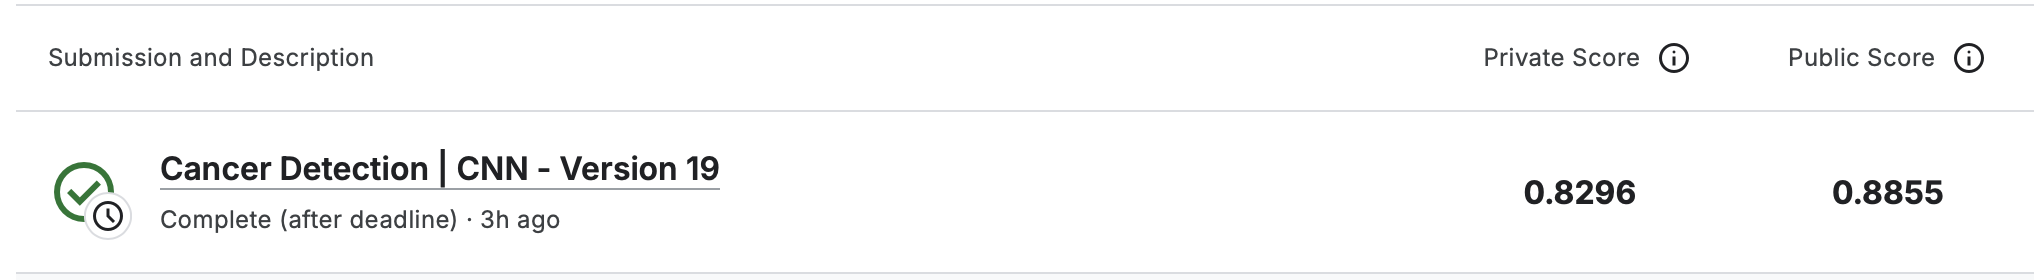

<div style="background-color: #76c7c0; color: white; padding: 10px; border-radius: 10px; text-align: center; font-size: 24px; font-weight: bold;">
    Conclusion
</div>

1. Model Performance Analysis

Model 1: 627,969 parameters, Validation Accuracy: 0.775
Model 2: 159,937 parameters, Validation Accuracy: 0.779
Despite having significantly fewer parameters, Model 2 slightly outperformed Model 1 in validation accuracy. This suggests that Model 1 might have been overfitting, as its higher complexity.

2. Insights from Training Metrics

Looking at the accuracy and loss plots:

Train accuracy consistently increases, while validation accuracy fluctuates more, which could indicate some instability or overfitting.
Validation loss shows significant spikes, suggesting the model struggled with certain epochs.

3. Learnings & Takeaways

What Helped Improve Performance:
* Reducing Model Complexity – Model 2 performed better with fewer parameters, reducing overfitting risk.
* Regularization techniques helped prevent extreme overfitting.

What Didn’t Help Much:
* Increasing model size (Model 1) – More parameters didn’t necessarily improve validation accuracy.
* Validation fluctuations – This suggests instability in training, possibly due to hyperparameter settings or dataset imbalance.
* Noisy loss trends – Validation loss spikes indicate room for better tuning.

4. Future Improvements & Next Steps

* Hyperparameter tuning
* Additional regularization
* Try alternative architectures
* Better early stopping criteria